# Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when submit. The list of files:
- This notebook
- assignment1_modules.ipynb
- assignment0_differentiation.ipynb

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib
import copy

%matplotlib inline

matplotlib.style.use('ggplot')

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [2]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you.
"""
%run assignment1_modules.ipynb

Optimizer is implemented for you. 

In [24]:
def sgd_momentum(x, dx, config, state, decay = False):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0.0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            cur_old_grad = config['momentum'] * cur_old_grad + (((1+i)**-1)*decay + (not decay))* config['learning_rate'] * cur_dx
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            np.add(cur_x, -cur_old_grad, out=cur_x)
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

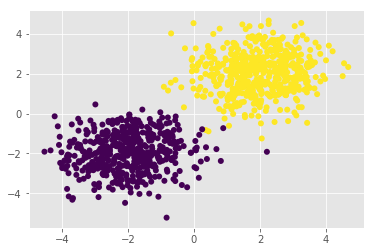

In [10]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [11]:
criterion = ClassNLLCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(SoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [12]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [13]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

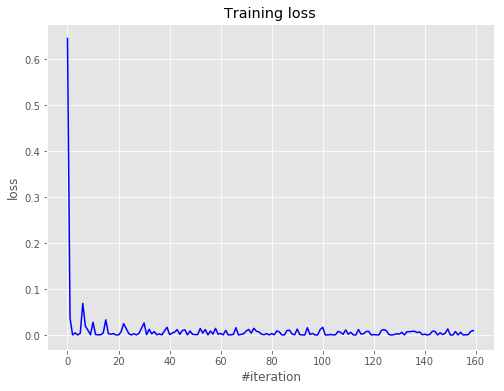

Current loss: 0.009602


In [14]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state, dec)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [15]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

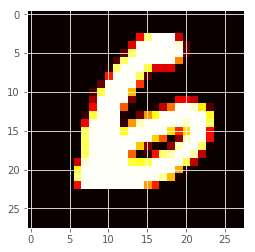

(70000, 784) (70000,)


In [16]:
a = copy.deepcopy(X[66666])
a = a.reshape(28,28)
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

print(X.shape, y.shape)

One-hot encode the labels first.

In [17]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
one_hot_y = np.array(enc.fit_transform(y.reshape(-1, 1)).todense())

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchMeanSubtraction` between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchMeanSubtraction` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [18]:
# Splitting my data into train, test and validation sets
# I devide data 60-5-5 to give my model as much training data as possible, yet leaving 
# enough data to test and validate my models

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, one_hot_y, test_size=1/7, random_state=111)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=1/2, random_state=111)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_validation.shape, y_validation.shape)

(60000, 784) (60000, 10)
(5000, 784) (5000, 10)
(5000, 784) (5000, 10)


/home/xoren/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
# Simple function to evaluate accurecy of model by percent

def acc(y_hat, y):
    t = 0
    for i in range(len(y)):
        t += np.argmax(y[i])==np.argmax(y_hat[i])
        
    return t / len(y) * 100
    

In [25]:
# Using your code from above :)

def train_nn(nn, n_epochs = 10, batch_size = 500, learning_rate = 1e-3, learning_rate_decay = False, momentum = 0.9):
    
    loss_history = []
    
    X= copy.deepcopy(X_train)
    Y = copy.deepcopy(y_train)
    
    optimizer_config = {'learning_rate' : learning_rate, 'momentum': momentum}
    optimizer_state = {}
    
    for i in range(n_epochs):
        for x_batch, y_batch in get_batches(X, Y, batch_size):
            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights            
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state, learning_rate_decay)      

            loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(16, 9))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()     
        
        print("Epoch: ",  i+1)
        print("Train Acc: ", acc(net.forward(X_train), y_train))
        print("Test Acc: ", acc(net.forward(X_test), y_test))
        print()
    
    print("-----------------------------------------------------------")
    print("Validation Acc: ", acc(net.forward(X_validation), y_validation))
    

Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

# Time to play around with models
## Markdown

$$and,  LaTex$$

# Now let's see if ReLu layer was really helping

In [15]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 300))
net.add(Linear(300, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 300
Linear 300 -> 10
SoftMax



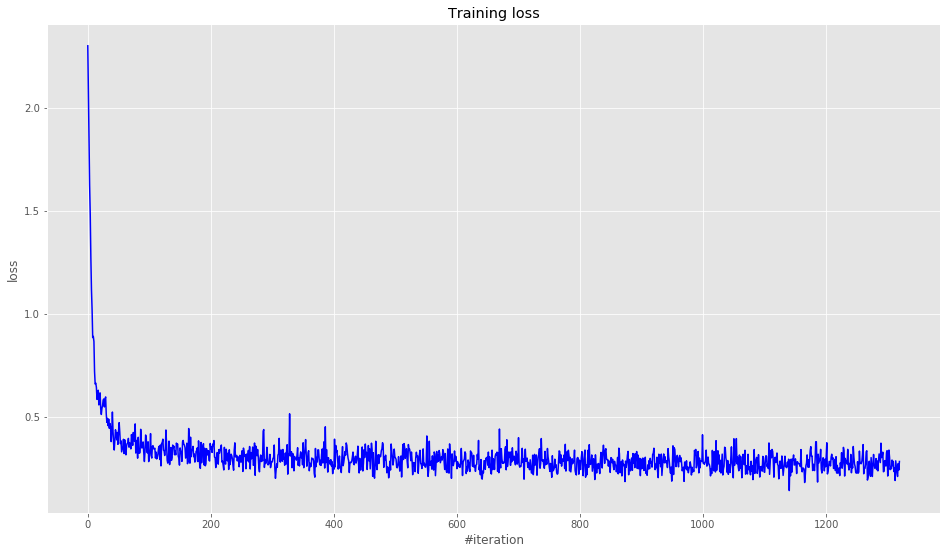

Epoch:  10
Train Acc:  92.5233333333
Test Acc:  92.0

-----------------------------------------------------------
Validation Acc:  91.16
CPU times: user 6min 40s, sys: 1min 28s, total: 8min 8s
Wall time: 2min 20s


In [16]:
%%time
train_nn(net)

# First let's add a ReLu layer, to add a noise

In [18]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 300))
net.add(ReLU())
net.add(Linear(300, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 300
ReLU
Linear 300 -> 10
SoftMax



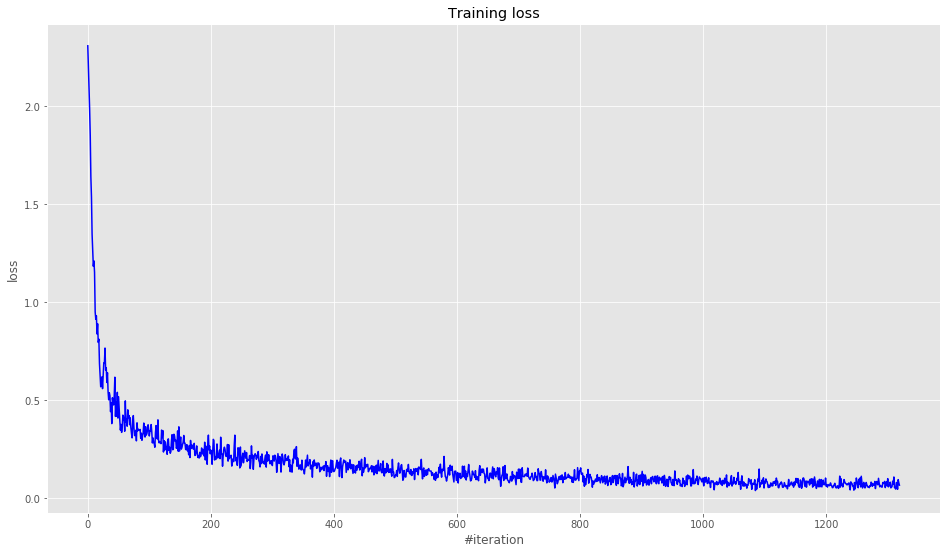

Epoch:  10
Train Acc:  98.3816666667
Test Acc:  97.3

-----------------------------------------------------------
Validation Acc:  97.18
CPU times: user 6min 53s, sys: 2min 3s, total: 8min 56s
Wall time: 2min 43s


In [19]:
%%time
train_nn(net)

# Obviously ReLu helped. Let's try LeakyReLU

In [21]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 300))
net.add(LeakyReLU())
net.add(Linear(300, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 300
LeakyReLU
Linear 300 -> 10
SoftMax



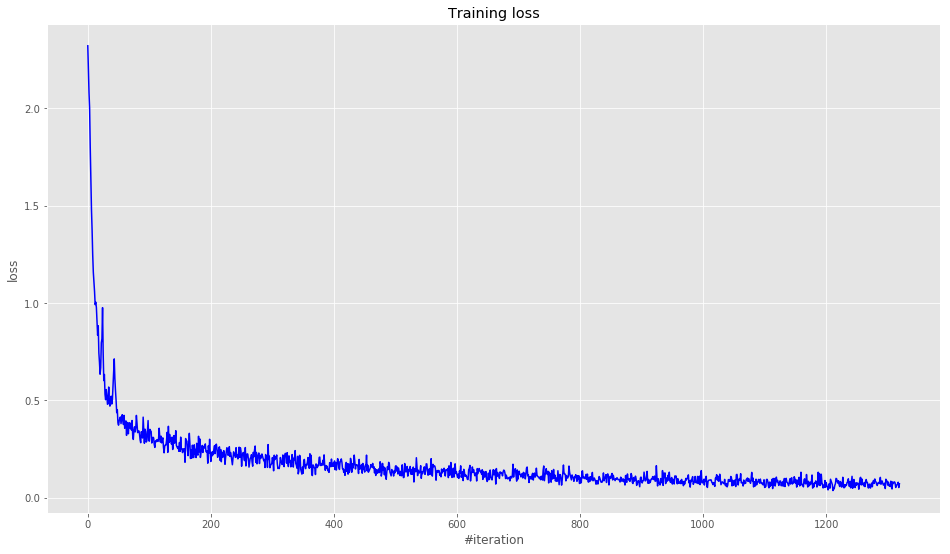

Epoch:  10
Train Acc:  98.2833333333
Test Acc:  97.5

-----------------------------------------------------------
Validation Acc:  97.16
CPU times: user 7min 6s, sys: 2min 25s, total: 9min 31s
Wall time: 2min 54s


In [22]:
%%time
train_nn(net)

## This didn't help much. Let's try out BatchMeanSubtraction

In [14]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 300))
net.add(BatchMeanSubtraction())
net.add(LeakyReLU())
net.add(Linear(300, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 300
BatchMeanNormalization
LeakyReLU
Linear 300 -> 10
SoftMax



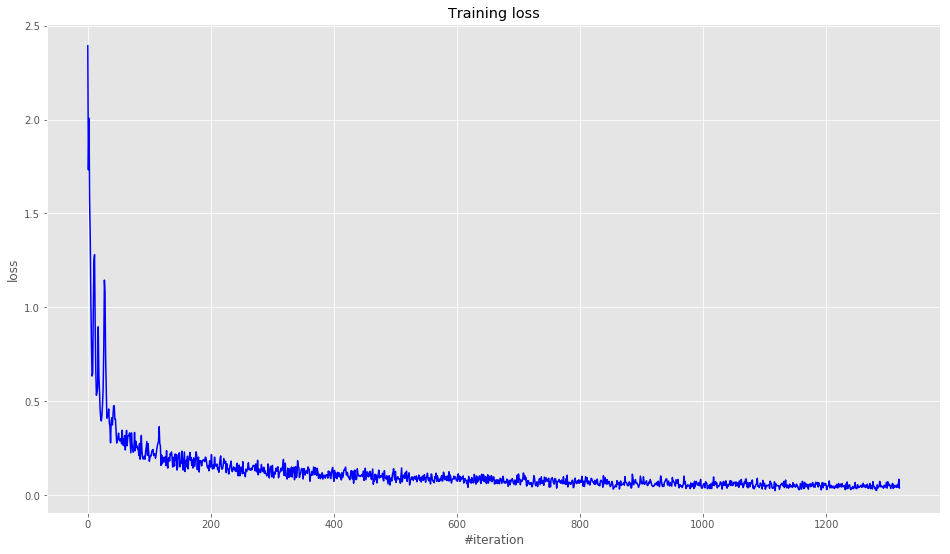

-----------------------------------------------------------
Validation Acc:  97.78
CPU times: user 7min 13s, sys: 2min 28s, total: 9min 42s
Wall time: 5min 7s


In [15]:
%%time
train_nn(net)

## BatchMeanSubstruct helped boost score more then half a percent. Let's add a Dropout layer and the number of epochs.

In [55]:
%run assignment1_modules.ipynb

In [58]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 300))
net.add(BatchMeanSubtraction())
net.add(Dropout(training=True))
net.add(LeakyReLU())
net.add(Linear(300, 10))
net.add(Dropout(training=True))
net.add(SoftMax())

print(net)

Linear 784 -> 300
BatchMeanNormalization
Dropout
LeakyReLU
Linear 300 -> 10
Dropout
SoftMax



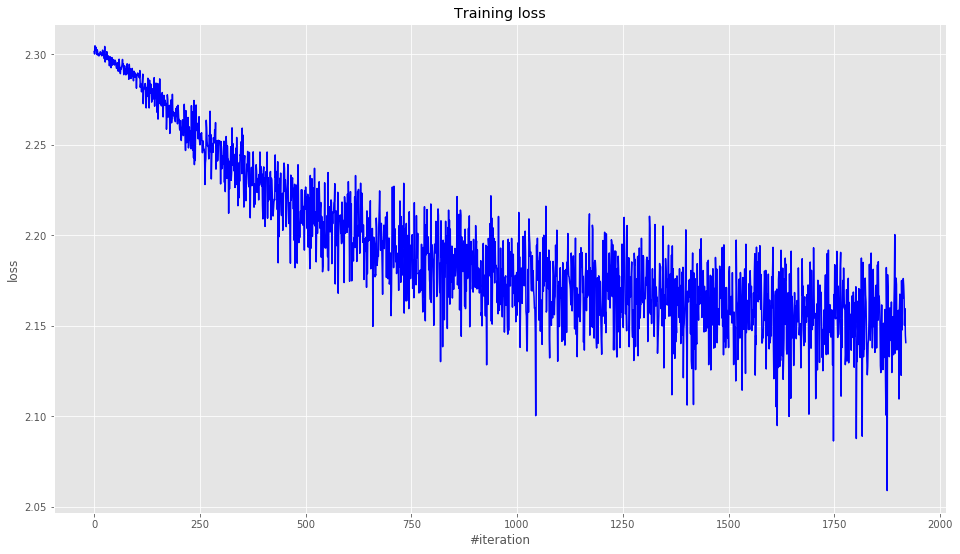

-----------------------------------------------------------
Validation Acc:  17.28
CPU times: user 10min 53s, sys: 4min 25s, total: 15min 18s
Wall time: 5min 43s


In [59]:
%%time
train_nn(net, n_epochs = 15)

## Droput layers didn't help, to put it mildely

This is not very suprising though, because our droput rate is pretty high and we have two such layers. Also, we've already introduced noise in our moel by LeakyReLU layer, and it seems that more noise won't help our model. 

# Let's try to increase the number of layers, to see if this increases predictive power

In [51]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 300))
net.add(BatchMeanSubtraction())
net.add(LeakyReLU())
net.add(Linear(300, 300))
net.add(LeakyReLU())
net.add(Linear(300, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 300
BatchMeanNormalization
LeakyReLU
Linear 300 -> 300
LeakyReLU
Linear 300 -> 10
SoftMax



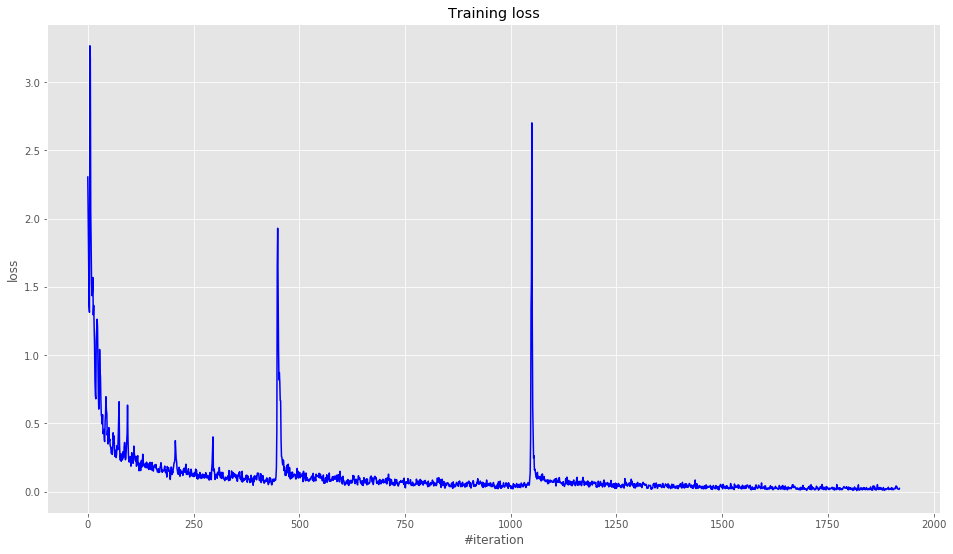

-----------------------------------------------------------
Validation Acc:  98.04
CPU times: user 14min 25s, sys: 5min 18s, total: 19min 43s
Wall time: 6min 7s


In [63]:
%%time
train_nn(net, n_epochs = 15)

## As can be seen from the plot, we had a big spike on about 450-th and 1150-th itterations. This is a perfect time to try out weather decaying learining rate can be usefull for our model
because these huge spikes are likely caused by the fact that brcause our learning rate stays constant, after coming close to the optimum, we "jump" from it, because of our learning rate. I modified sgd_momentum and train_nn functions to include optional parameter learning_rate_decay, which is set by default to False

In [28]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 300))
net.add(BatchMeanSubtraction())
net.add(LeakyReLU())
net.add(Linear(300, 300))
net.add(LeakyReLU())
net.add(Linear(300, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 300
BatchMeanNormalization
LeakyReLU
Linear 300 -> 300
LeakyReLU
Linear 300 -> 10
SoftMax



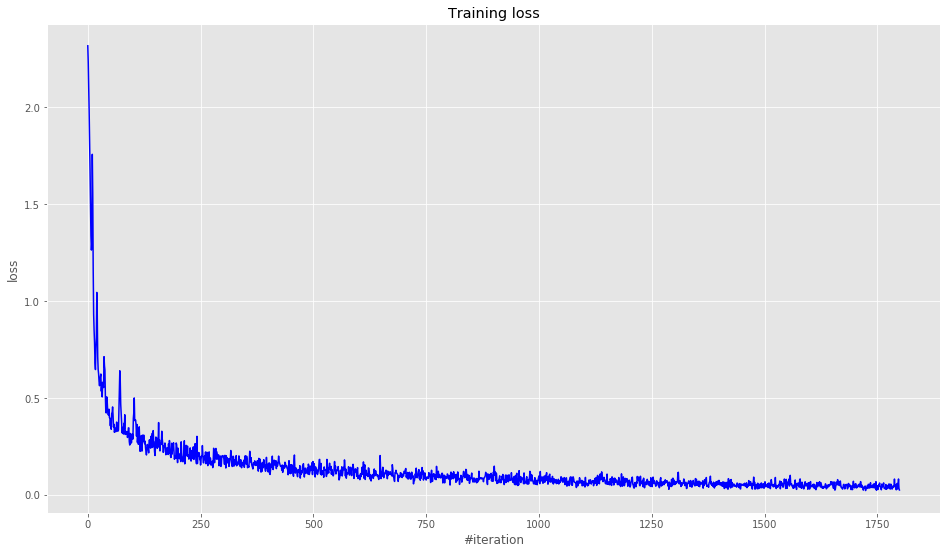

Epoch:  15
Train Acc:  99.1016666667
Test Acc:  97.5

-----------------------------------------------------------
Validation Acc:  97.66
CPU times: user 13min 37s, sys: 4min 17s, total: 17min 55s
Wall time: 5min 42s


In [29]:
%%time
train_nn(net, n_epochs = 15, learning_rate_decay=True)

After using learing_raet_decay parameter, the bumps in our curve dessapeared, but validation accurecy decreased a little bit.

# So after trying couple of models, we obtained 98% validation score. Which is not bad, taking into account the fact, that we didn't use conv layers

# Best model was...

In [ ]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 300))
net.add(BatchMeanSubtraction())
net.add(LeakyReLU())
net.add(Linear(300, 300))
net.add(LeakyReLU())
net.add(Linear(300, 10))
net.add(SoftMax())

print(net)

## Let's try to compare the effect of using input normalization
For this we'll also mesure the execution time, to observe gain in speed too

# Autoencoder (optional) 

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
![](../imgs/autoencoder.png)

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [218]:
# Your code goes here. ################################################

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [219]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [220]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################